# Reproduce the heatmap from inferCNV

This document demonstrates to reproduce how the [example heatmap](https://github.com/broadinstitute/inferCNV/wiki#demo-example-figure) from the original
R inverCNV implementation. It is based on a small, 183-cell example dataset of malignant and non-malignant cells from Oligodendroglioma derived from [Tirosh et al. (2016)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5465819/). 

In [1]:
import infercnvpy as cnv
import scanpy as sc

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


/opt/hostedtoolcache/Python/3.8.7/x64/lib/python3.8/site-packages/traitlets/traitlets.py:3030: FutureWarning: --rc={'figure.dpi': 96} for dict-traits is deprecated in traitlets 5.0. You can pass --rc <key=value> ... multiple times to add items to a dict.
  warn(


INFO:get_version:dirname: Trying to get version of get_version from dirname /opt/hostedtoolcache/Python/3.8.7/x64/lib/python3.8/site-packages


INFO:get_version:dirname: Failed; Does not match re.compile('get[_-]version-([\\d.]+?)(?:\\.dev(\\d+))?(?:[_+-]([0-9a-zA-Z.]+))?$')


INFO:get_version:git: Trying to get version from git in directory /opt/hostedtoolcache/Python/3.8.7/x64/lib/python3.8/site-packages


INFO:get_version:git: Failed; directory is not managed by git


INFO:get_version:metadata: Trying to get version for get_version in dir /opt/hostedtoolcache/Python/3.8.7/x64/lib/python3.8/site-packages


INFO:get_version:metadata: Succeeded


INFO:get_version:dirname: Trying to get version of legacy_api_wrap from dirname /opt/hostedtoolcache/Python/3.8.7/x64/lib/python3.8/site-packages


INFO:get_version:dirname: Failed; Does not match re.compile('legacy[_-]api[_-]wrap-([\\d.]+?)(?:\\.dev(\\d+))?(?:[_+-]([0-9a-zA-Z.]+))?$')


INFO:get_version:git: Trying to get version from git in directory /opt/hostedtoolcache/Python/3.8.7/x64/lib/python3.8/site-packages


INFO:get_version:git: Failed; directory is not managed by git


INFO:get_version:metadata: Trying to get version for legacy_api_wrap in dir /opt/hostedtoolcache/Python/3.8.7/x64/lib/python3.8/site-packages


INFO:get_version:metadata: Succeeded


## Prepare and inspect dataset
The example dataset is available in the `datasets` module. It is already TPM-normalized, but not log-transformed. 

In [2]:
adata = cnv.datasets.oligodendroglioma()
sc.pp.log1p(adata)

It also already has the genomic positions annotated in`adata.var`: 

In [3]:
adata.var.head()

,chromosome,start,end,n_counts,n_cells
gene_symbol,,,,,
WASH7P,chr1,14363,29806,534.271301,116
LINC00115,chr1,761586,762902,203.649094,18
NOC2L,chr1,879584,894689,880.449707,63
SDF4,chr1,1152288,1167411,1013.251404,70
UBE2J2,chr1,1189289,1209265,411.488953,33


It contains four types of malignant cells, and two clusters of non-malignant cells. 

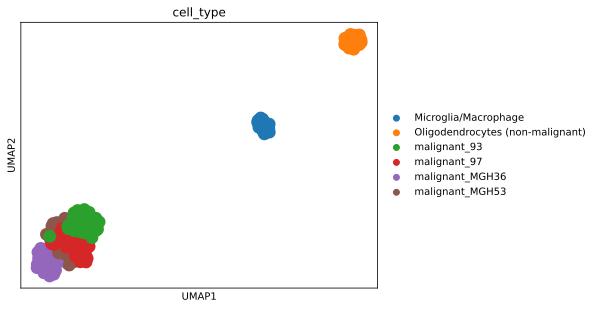

In [4]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="cell_type")

## Run infercnvpy

In this case we know which cells are non-malignant. For best results, it is recommended to use
the non-malignant cells as a background. We can provide this information using `reference_key` and `reference_cat`. 

In order to reproduce the results as exactely as possible, we use a `window_size` of 100 and a `step` of 1. 

In [5]:
%%time
cnv.tl.infercnv(
    adata, 
    reference_key="cell_type", 
    reference_cat=["Oligodendrocytes (non-malignant)", "Microglia/Macrophage"], 
    window_size=100,
    step=1,
)

/opt/hostedtoolcache/Python/3.8.7/x64/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

CPU times: user 39.2 ms, sys: 28.2 ms, total: 67.4 ms
Wall time: 631 ms


         Falling back to preprocessing with `sc.pp.pca` and default params.


categories: Microglia/Macrophage, Oligodendrocytes (non-malignant), malignant_93, etc.
var_group_labels: chr1, chr2, chr3, etc.


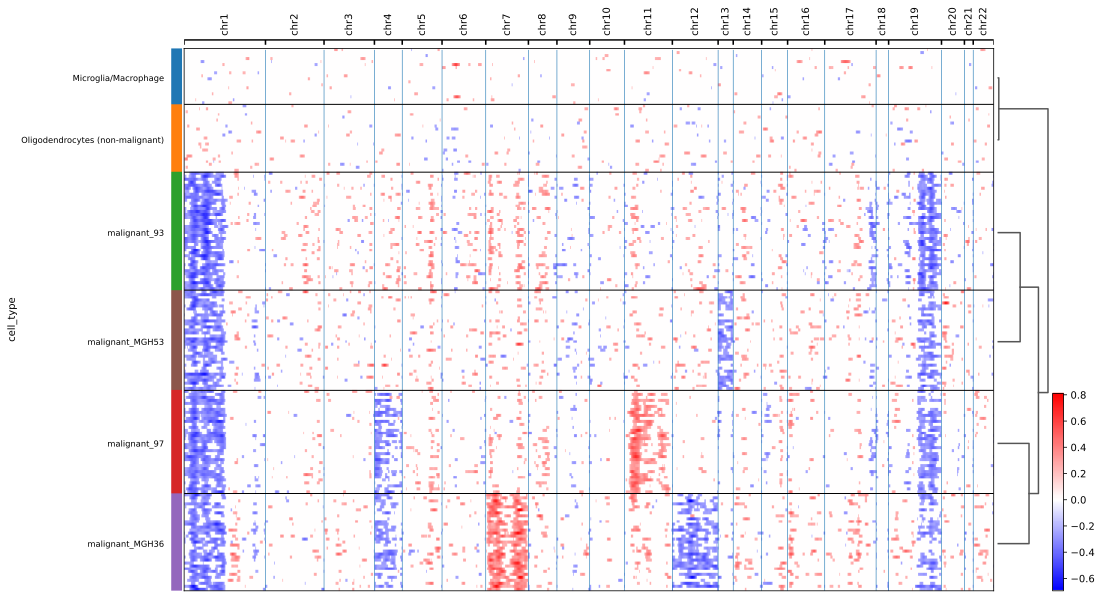

CPU times: user 1.02 s, sys: 196 ms, total: 1.22 s
Wall time: 1.03 s


In [6]:
%%time
cnv.pl.chromosome_heatmap(adata, groupby="cell_type", dendrogram=True)

Note that running the same analysis in R (`invercnv v1.6.0` from Bioconductor) takes about 1:30 min. 